# Simulazione diffusione Compton multipla per fotoni emessi da una sorgente di Cesio

Questo programma simula la diffusione Compton di un fascio di fotoni all'interno di un cristallo del detector.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import curve_fit
#%matplotlib

Definiamo
i parametri del problema: la massa dell'elettrone $m_e=511\,keV$ e l'energia nominale del fotone emesso dal decadimento del Cesio $E_{Cs} = 661.7\,keV$

In [2]:
m_e=551 #keV
E_init=E_Cs=661.7 #keV

Simuliamo il passaggio di un grande numero (10000000) di fotoni

In [12]:
N_photon=100 #number of incident photons

La formula per la sezione d'urto differenziale angolare dell'effetto Compton è nota come formula di Klein-Nishima. Se $E$ ed $E'$ sono rispettivamente l'energia del fotone incidente e diffuso, e $\theta$ è l'angolo di diffusione, vale

$$
\frac{E'}{E} = \frac{1}{1+\frac{E}{m_e}(1-\cos{\theta})}
$$
 
e

$$
\frac{d\sigma}{d\cos{\theta}} = \mathcal{A} \bigg(\frac{E'}{E}\bigg)^{2} \bigg(\frac{E}{E'} + \frac{E'}{E} - \sin^{2}{\theta}\bigg)
$$

Dove $\mathcal{A}$ è un irrilevante fattore moltiplicativo che si elide normalizzando questa distribuzione.

Imponendo $\frac{d\sigma}{d\cos{\theta}} d\cos{\theta} = \frac{d\sigma}{dE'} dE'$ otteniamo la sezione d'urto differenziale in energia, che implementiamo in una funzione nella prossima cella.

La cinematica imposta un intervallo possibile di energie del fotone diffuso che dipende dall'energia del fotone incidente $E$: $I_{E} = [\frac{m_e}{m_e + 2 E} E, E]$. Per semplificare il codice delle prossime celle, implementiamo una funzione che resistuisca un ```arange``` di numpy in questo intervallo.

Integrando questa espressione su tutti i valori delle energie finali, si trova la sezione d'urto totale in funzione dell'energia incidente. Normalizzando opportunamente questa funzione, otteniamo una distribuzione di probabilità per l'interazione del fotone con il cristallo attraverso l'effetto Compton.

In [4]:
#range of definition of d(sigma)/d(E_out) in function of E_in (defaults to E_Cs)
def sample(E=E_init, step=0.5):
    return np.linspace(0.1+(m_e*E/(m_e+2*E)), E, 10000)

#d(sigma)/d(E_out) with e_in (defaults to E_Cs) as a parameter, computed from the Klein-Nishima formula
def differentialCrossSection(E_out, E_in=E_init):
    x=np.arccos(m_e/E_in - m_e/E_out + 1)
    return (E_out/E_in)*(E_in/E_out + E_out/E_in - np.sin(x)*np.sin(x))

#integrated cross-section as a function of energy
def totalCrossSection(E):
    x=E/m_e
    return 0.75*(((1+x)/(x**3))*((2*x*(1+x)/(1+2*x)) - np.log(1+2*x)))+(1/(2*x))*np.log(1+2*x) -((1+3*x)/((1+2*x)**2))
        
E_max=10000
x=np.arange(100,E_max, 0.005)
normalization=integrate.trapz(totalCrossSection(x), x) #normalization of the total cross section

Per simulare la diffusione, generiamo numeri aleatori da una distribuzione uniforme tra 0 e 1, e li confrontiamo con la distribuzione di probabilità di cui sopra per decidere se il fotone interagisce per effetto Compton.

Per generare l'energia del fotone uscente, discretizziamo l'asse delle energie del fotone diffuso (o meglio, l'intervallo di definizione di cui sopra), e estraiamo casualmente da una distribuzione di probabilità discreta, calcolata come 
$$
\frac{d\,\sigma}{d\,E'}(E'_k)
$$
il valore dell'energia del fotone uscente.

In [10]:
def scattering(E=E_init):
    multiple=0
    while np.random.uniform()<((totalCrossSection(E))/(normalization)): #if it interacts...
        E=np.random.choice(sample(E),p=differentialCrossSection(sample(E),E)/differentialCrossSection(sample(E),E).sum()) #it comes out with a random energy
        multiple+=1 #count the number of interactions
    return E, multiple #return the energy at end of process and the number of Compton scatterings

Per ciascun fotone, iteriamo il processo di decisione aleatoria dell'interazione, e salviamo le energie finali di ciascun fotone nell'array ```energies``` . Il tempo di esecuzione è piuttosto lungo a causa del numero di operazioni che deve eseguire per ciascun fotone.

In [15]:
energies=np.array([scattering() for photon in range(0, N_photon)])

In [7]:
#def fit_function(x, par0, par1, par2, par3, par4, par5, par6):
 #   return par0+par1*x+par2*(x**2)+par3*(x**3)+par4*(x**4)+par5*(x**5)+par6*(x**6)

Di seguito mostriamo l'istogramma dello spettro delle energie rilasciate nel detector, i.e.

$$
\Delta E^{i}=E_{Cs} - \text{energies}^{i}
$$

In [8]:
hist, bins=np.histogram(E_init-energies[:,0][np.where(energies[:,0]!=E_init)], 50)
bins=np.array([0.5*bins[i]+bins[i+1] for i in range (0,len(bins)-1)])
#popt, pcov=curve_fit(fit_function, xdata=bins, ydata=hist)

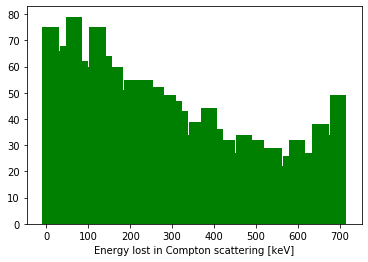

In [9]:
x=np.linspace(0,E_init,10000)
fig=plt.figure()
plt.bar(bins,hist,40, color='g')
#plt.plot(x, fit_function(x,*popt), color='b')
plt.xlabel("Energy lost in Compton scattering [keV]")
plt.savefig("/tmp/compton.jpg")

Si vede che la grandissima maggioranza dei fotoni incidenti non interagisce affatto per effetto compton, e la frazione di fotoni che partecipano ad una diffusione multipla è essenzialmente 0 simulando il passaggio di 10000000 fotoni nel cristallo.